In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)


In [ ]:
# Load and examine the data
df = pd.read_csv('../data/ai_tools_2.csv')

print("Dataset shape:", df.shape)
print("\nAI Tools included:")
for i, tool in enumerate(df['Ai_tools'], 1):
    print(f"{i}. {tool}")

print(f"\nTotal columns: {len(df.columns)}")
print("Sample of column names:")
print(df.columns[:10].tolist())

df.head()


In [ ]:
# Data preprocessing functions
def time_to_seconds(time_str):
    """Convert MM:SS.s format to seconds"""
    if pd.isna(time_str) or time_str == 'rejected':
        return None
    try:
        parts = time_str.split(':')
        minutes = int(parts[0])
        seconds = float(parts[1])
        return minutes * 60 + seconds
    except:
        return None

def is_successful(value):
    """Check if a submission was successful (not rejected)"""
    return pd.notna(value) and value != 'rejected'

# Extract problem columns (A through P)
problem_cols = [col for col in df.columns if len(col) == 1 and col.isalpha() and 'A' <= col <= 'P']
print(f"Problem columns identified: {problem_cols}")
print(f"Total problems: {len(problem_cols)}")

# Verify data structure
print(f"\nData verification:")
for tool in df['Ai_tools']:
    row = df[df['Ai_tools'] == tool].iloc[0]
    successful_problems = sum(1 for col in problem_cols if is_successful(row[col]))
    print(f"{tool}: {successful_problems}/{len(problem_cols)} problems solved")


In [ ]:
# Calculate success rates and performance metrics
performance_data = []

for tool in df['Ai_tools']:
    row = df[df['Ai_tools'] == tool].iloc[0]
    
    successful_problems = 0
    response_times = []
    
    for problem in problem_cols:
        if is_successful(row[problem]):
            successful_problems += 1
            time_sec = time_to_seconds(row[problem])
            if time_sec is not None:
                response_times.append(time_sec)
    
    success_rate = (successful_problems / len(problem_cols)) * 100
    avg_time = np.mean(response_times) if response_times else 0
    median_time = np.median(response_times) if response_times else 0
    
    performance_data.append({
        'Tool': tool,
        'Success_Rate': success_rate,
        'Successful_Problems': successful_problems,
        'Total_Problems': len(problem_cols),
        'Avg_Response_Time': avg_time,
        'Median_Response_Time': median_time,
        'Response_Times': response_times
    })

# Create performance DataFrame
perf_df = pd.DataFrame(performance_data)
perf_df = perf_df.sort_values('Success_Rate', ascending=False)

print("=== AI TOOLS PERFORMANCE RANKING ===")
for i, row in perf_df.iterrows():
    print(f"{row.name + 1}. {row['Tool']}")
    print(f"   Success Rate: {row['Success_Rate']:.1f}% ({row['Successful_Problems']}/{row['Total_Problems']})")
    print(f"   Avg Response Time: {row['Avg_Response_Time']:.1f}s")
    print()


In [ ]:
# Visualization 1: Success Rate Comparison
plt.figure(figsize=(14, 8))
bars = plt.bar(perf_df['Tool'], perf_df['Success_Rate'], 
               color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'])

plt.title('AI Tools Success Rate Comparison\nNUCPA Contest Performance', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('AI Programming Tools', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.ylim(0, 100)

# Add value labels on bars
for bar, rate in zip(bars, perf_df['Success_Rate']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add horizontal grid
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Display ranking table
print("\\n📊 SUCCESS RATE RANKING:")
for idx, (_, row) in enumerate(perf_df.iterrows()):
    rank_emoji = ["🥇", "🥈", "🥉", "4️⃣", "5️⃣"][idx]
    print(f"{rank_emoji} {row['Tool']}: {row['Success_Rate']:.1f}% ({row['Successful_Problems']}/16 problems)")


In [ ]:
# Visualization 2: Response Time Analysis
tools_with_times = perf_df[perf_df['Avg_Response_Time'] > 0].copy()
tools_with_times = tools_with_times.sort_values('Avg_Response_Time')

plt.figure(figsize=(12, 6))
bars = plt.bar(tools_with_times['Tool'], tools_with_times['Avg_Response_Time'], 
               color=['#2ca02c', '#1f77b4', '#ff7f0e', '#d62728'])

plt.title('Average Response Time for Successful Solutions', fontsize=16, fontweight='bold')
plt.xlabel('AI Tools', fontsize=12)
plt.ylabel('Average Response Time (seconds)', fontsize=12)

# Add value labels
for bar, time in zip(bars, tools_with_times['Avg_Response_Time']):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{time:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print("⚡ SPEED RANKING (for successful solutions):")
for idx, (_, row) in enumerate(tools_with_times.iterrows()):
    print(f"{idx+1}. {row['Tool']}: {row['Avg_Response_Time']:.1f}s average response time")


In [ ]:
# Problem Difficulty Analysis
problem_difficulty = {}

for problem in problem_cols:
    successes = 0
    for tool in df['Ai_tools']:
        row = df[df['Ai_tools'] == tool].iloc[0]
        if is_successful(row[problem]):
            successes += 1
    
    success_rate = (successes / len(df)) * 100
    problem_difficulty[problem] = success_rate

# Sort problems by difficulty (success rate)
problems_sorted = sorted(problem_difficulty.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(16, 8))
problems, rates = zip(*problems_sorted)
bars = plt.bar(problems, rates, color=plt.cm.RdYlGn([r/100 for r in rates]))

plt.title('Problem Difficulty Analysis\nSuccess Rate Across All AI Tools', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Contest Problems', fontsize=12)
plt.ylabel('AI Success Rate (%)', fontsize=12)
plt.ylim(0, 100)

# Add value labels
for bar, rate in zip(bars, rates):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.0f}%', ha='center', va='bottom', fontweight='bold')

plt.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Categorize problems by difficulty
easy_problems = [p for p, r in problems_sorted if r >= 80]
medium_problems = [p for p, r in problems_sorted if 40 <= r < 80]  
hard_problems = [p for p, r in problems_sorted if 20 <= r < 40]
impossible_problems = [p for p, r in problems_sorted if r < 20]

print("\\n🎯 PROBLEM DIFFICULTY CATEGORIES:")
print(f"✅ Easy (≥80% AI success): {easy_problems}")
print(f"⚠️  Medium (40-79% AI success): {medium_problems}")
print(f"❌ Hard (20-39% AI success): {hard_problems}")
print(f"💀 Near Impossible (<20% AI success): {impossible_problems}")


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

# Set display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("AI Tools Performance Analysis with Rejections")
print("=" * 50)

AI Tools Performance Analysis with Rejections


In [34]:

# Load the CSV file with proper encoding
df = pd.read_csv('../data/ai_tools_2.csv', encoding='utf-8-sig')

# Define problem letters and tool names
problems = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
print(f"Analyzing {len(problems)} problems: {', '.join(problems)}")
print(f"Number of AI tools: {len(df)}")

# Display basic information
print("\nDataset shape:", df.shape)
print("\nAI Tools being analyzed:")
for i, tool in enumerate(df['Ai_tools'], 1):
    print(f"  {i}. {tool}")

print(f"\nColumns in dataset: {len(df.columns)} total")
print("  - 1 tool name column")
print("  - 16 time columns (A-P)")
print("  - 16 time complexity columns") 
print("  - 16 memory usage columns")

Analyzing 16 problems: A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P
Number of AI tools: 5

Dataset shape: (5, 49)

AI Tools being analyzed:
  1. Chat GPT
  2. Deepseek
  3. Claude
  4. Gemini - Google
  5. Github_copilot

Columns in dataset: 49 total
  - 1 tool name column
  - 16 time columns (A-P)
  - 16 time complexity columns
  - 16 memory usage columns


In [35]:
# Function to convert time strings to seconds, handling rejections
def time_to_seconds(time_str):
    """Convert MM:SS.S format to seconds, return None for rejected/invalid entries"""
    if pd.isna(time_str) or time_str == 'rejected' or str(time_str).strip() == '':
        return None
    try:
        if ':' in str(time_str):
            parts = str(time_str).split(':')
            return int(parts[0]) * 60 + float(parts[1])
    except:
        return None
    return None

# Process the data to calculate success rates and performance metrics
tool_analysis = {}

print("\n" + "="*60)
print("PROCESSING DATA WITH REJECTION HANDLING")
print("="*60)

for _, row in df.iterrows():
    tool_name = row['Ai_tools']
    times = []
    rejections = 0
    successful_problems = []
    
    for problem in problems:
        time_val = row[problem]
        complexity_val = row[f'{problem}_time complexity']
        memory_val = row[f'{problem}_memory']
        
        # A problem is rejected if BOTH complexity and memory show "rejected"
        if (complexity_val == 'rejected' and memory_val == 'rejected') or not time_val or str(time_val).strip() == '':
            rejections += 1
        else:
            # Convert time to seconds
            seconds = time_to_seconds(time_val)
            if seconds is not None:
                times.append(seconds)
                successful_problems.append(problem)
            else:
                rejections += 1
    
    success_rate = (len(problems) - rejections) / len(problems) * 100
    avg_time = np.mean(times) if times else 0
    
    tool_analysis[tool_name] = {
        'success_rate': success_rate,
        'problems_solved': len(problems) - rejections,
        'rejections': rejections,
        'times': times,
        'avg_time': avg_time,
        'min_time': min(times) if times else 0,
        'max_time': max(times) if times else 0,
        'successful_problems': successful_problems
    }
    
    print(f"\n{tool_name}:")
    print(f"  Success Rate: {success_rate:.1f}% ({len(problems)-rejections}/{len(problems)} problems)")
    print(f"  Average Time: {avg_time:.2f}s")
    if times:
        print(f"  Time Range: {min(times):.1f}s - {max(times):.1f}s")
        print(f"  Successful Problems: {', '.join(successful_problems)}")


PROCESSING DATA WITH REJECTION HANDLING

Chat GPT:
  Success Rate: 43.8% (7/16 problems)
  Average Time: 23.47s
  Time Range: 11.5s - 31.1s
  Successful Problems: A, B, I, K, L, M, O

Deepseek:
  Success Rate: 31.2% (5/16 problems)
  Average Time: 30.74s
  Time Range: 23.0s - 55.8s
  Successful Problems: A, B, I, K, O

Claude:
  Success Rate: 62.5% (10/16 problems)
  Average Time: 15.46s
  Time Range: 10.8s - 25.7s
  Successful Problems: A, B, C, E, G, I, L, M, N, O

Gemini - Google:
  Success Rate: 18.8% (3/16 problems)
  Average Time: 4.97s
  Time Range: 3.8s - 6.2s
  Successful Problems: I, K, O

Github_copilot:
  Success Rate: 43.8% (7/16 problems)
  Average Time: 8.77s
  Time Range: 6.3s - 13.0s
  Successful Problems: A, B, G, H, I, K, O


In [36]:
# Create summary DataFrame for visualization
summary_data = []
for tool_name, data in tool_analysis.items():
    summary_data.append({
        'Tool': tool_name,
        'Success_Rate': data['success_rate'],
        'Problems_Solved': data['problems_solved'],
        'Rejections': data['rejections'],
        'Avg_Time': data['avg_time'],
        'Min_Time': data['min_time'],
        'Max_Time': data['max_time']
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Success_Rate', ascending=False)

print("\n" + "="*60)
print("PERFORMANCE SUMMARY TABLE")
print("="*60)
print(summary_df.round(2))

# Print rankings
print("\n" + "="*60)
print("TOOL RANKINGS BY SUCCESS RATE")
print("="*60)
for i, (_, row) in enumerate(summary_df.iterrows(), 1):
    print(f"{i}. {row['Tool']}: {row['Success_Rate']:.1f}% success rate ({row['Problems_Solved']}/16 problems)")
    print(f"   Average time for successful solutions: {row['Avg_Time']:.1f}s")


PERFORMANCE SUMMARY TABLE
              Tool  Success_Rate  Problems_Solved  Rejections  Avg_Time  \
2           Claude         62.50               10           6     15.46   
0         Chat GPT         43.75                7           9     23.47   
4   Github_copilot         43.75                7           9      8.77   
1         Deepseek         31.25                5          11     30.74   
3  Gemini - Google         18.75                3          13      4.97   

   Min_Time  Max_Time  
2      10.8      25.7  
0      11.5      31.1  
4       6.3      13.0  
1      23.0      55.8  
3       3.8       6.2  

TOOL RANKINGS BY SUCCESS RATE
1. Claude: 62.5% success rate (10/16 problems)
   Average time for successful solutions: 15.5s
2. Chat GPT: 43.8% success rate (7/16 problems)
   Average time for successful solutions: 23.5s
3. Github_copilot: 43.8% success rate (7/16 problems)
   Average time for successful solutions: 8.8s
4. Deepseek: 31.2% success rate (5/16 problems)
   Aver

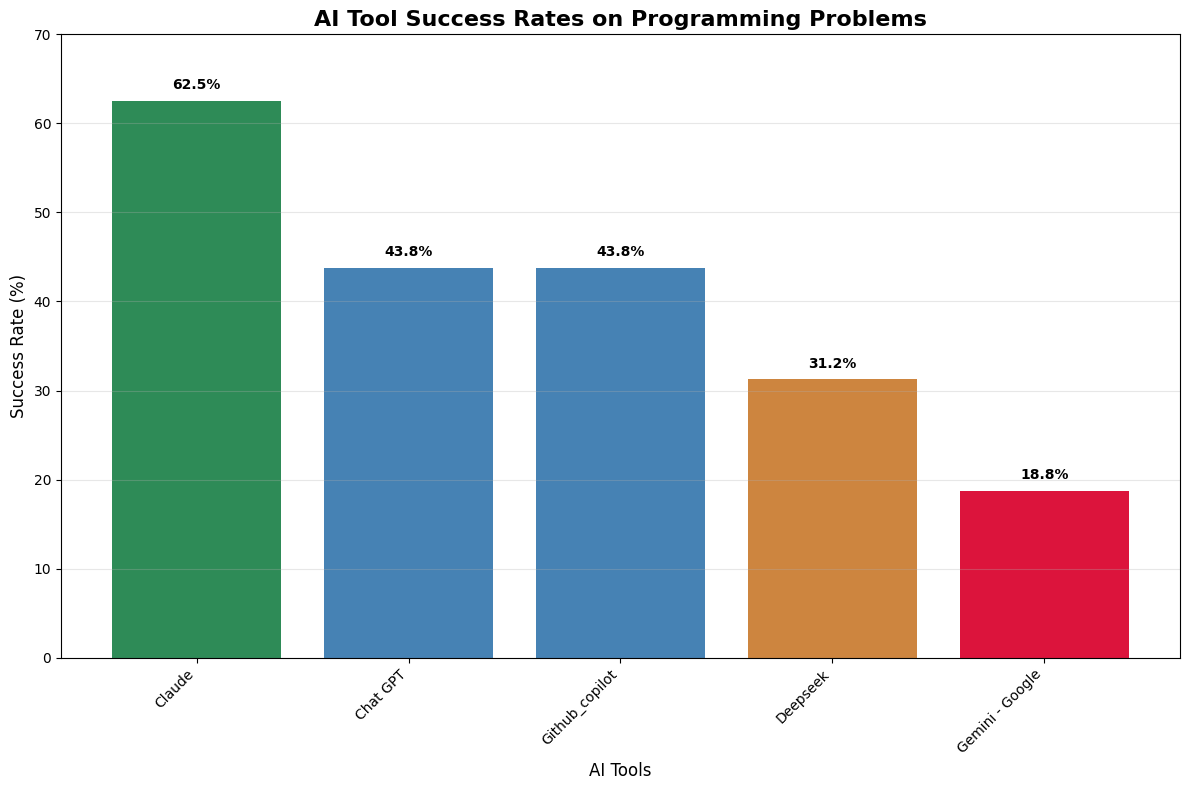

In [37]:

# 1. Success Rate Comparison Chart
plt.figure(figsize=(12, 8))
colors = ['#2E8B57', '#4682B4', '#4682B4', '#CD853F', '#DC143C']  # Green for best, red for worst
bars = plt.bar(summary_df['Tool'], summary_df['Success_Rate'], color=colors)
plt.title('AI Tool Success Rates on Programming Problems', fontsize=16, fontweight='bold')
plt.ylabel('Success Rate (%)', fontsize=12)
plt.xlabel('AI Tools', fontsize=12)
plt.ylim(0, 70)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

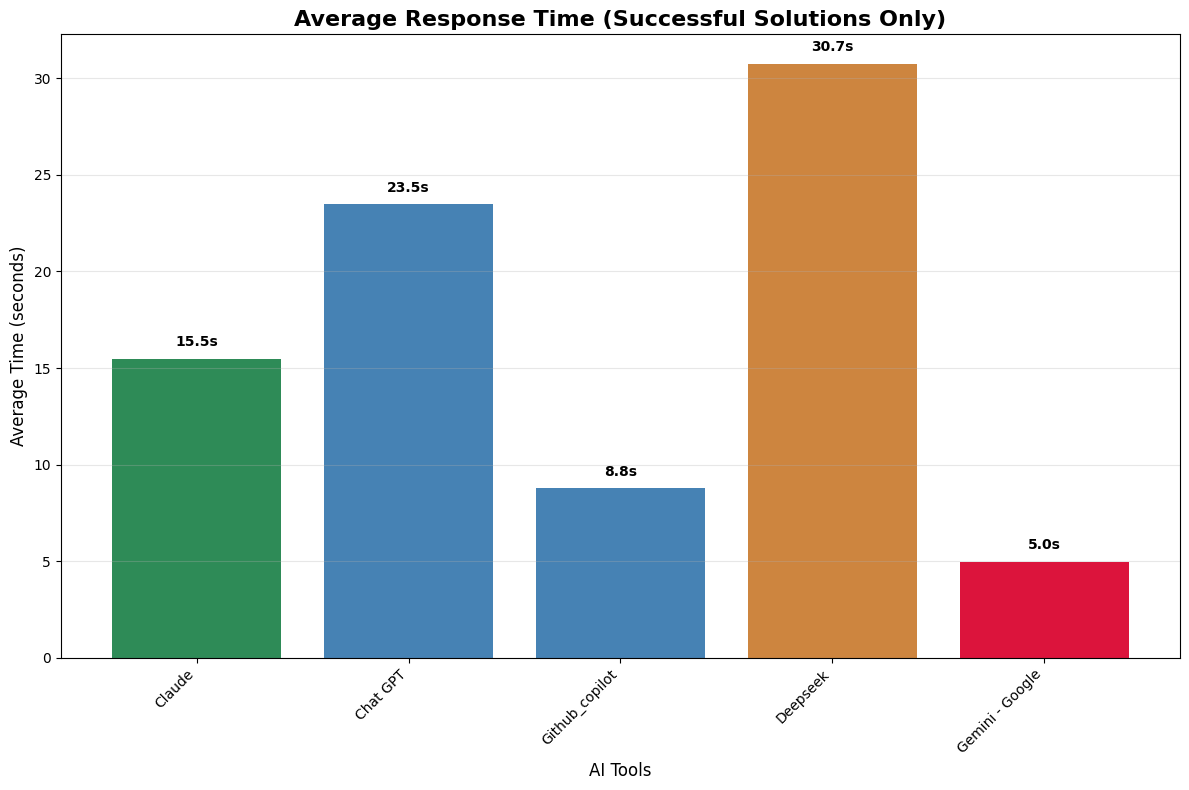

In [38]:
# 2. Average Response Time for Successful Solutions
plt.figure(figsize=(12, 8))
successful_tools = summary_df[summary_df['Avg_Time'] > 0]
colors_subset = ['#2E8B57', '#4682B4', '#4682B4', '#CD853F', '#DC143C'][:len(successful_tools)]
bars = plt.bar(successful_tools['Tool'], successful_tools['Avg_Time'], color=colors_subset)
plt.title('Average Response Time (Successful Solutions Only)', fontsize=16, fontweight='bold')
plt.ylabel('Average Time (seconds)', fontsize=12)
plt.xlabel('AI Tools', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


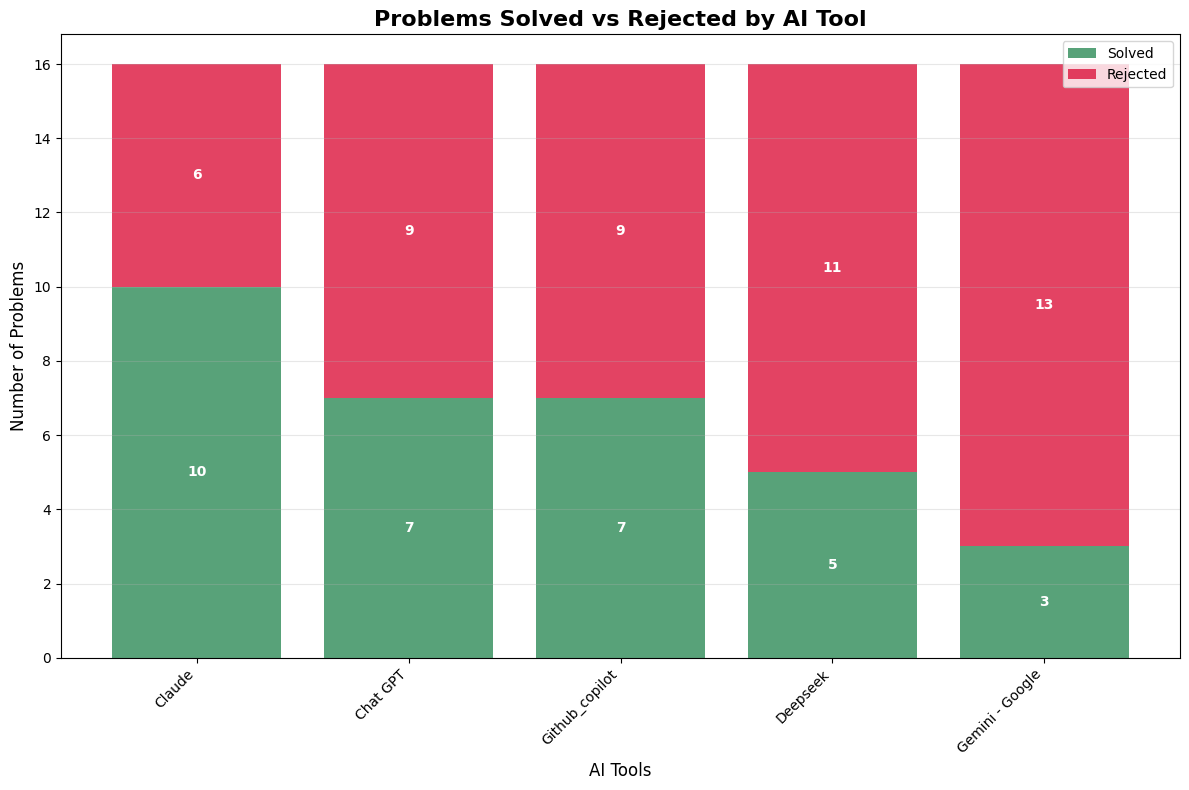

In [40]:
# 3. Problems Solved vs Rejected Stacked Bar Chart
plt.figure(figsize=(12, 8))
x_pos = range(len(summary_df))
bars_solved = plt.bar(x_pos, summary_df['Problems_Solved'], label='Solved', color='#2E8B57', alpha=0.8)
bars_rejected = plt.bar(x_pos, summary_df['Rejections'], bottom=summary_df['Problems_Solved'], 
                       label='Rejected', color='#DC143C', alpha=0.8)
plt.title('Problems Solved vs Rejected by AI Tool', fontsize=16, fontweight='bold')
plt.ylabel('Number of Problems', fontsize=12)
plt.xlabel('AI Tools', fontsize=12)
plt.xticks(x_pos, summary_df['Tool'], rotation=45, ha='right')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars_solved):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height/2,
             f'{int(height)}', ha='center', va='center', fontweight='bold', color='white')

for i, bar in enumerate(bars_rejected):
    height = bar.get_height()
    y_pos = summary_df.iloc[i]['Problems_Solved'] + height/2
    plt.text(bar.get_x() + bar.get_width()/2., y_pos,
             f'{int(height)}', ha='center', va='center', fontweight='bold', color='white')

plt.tight_layout()
plt.show()


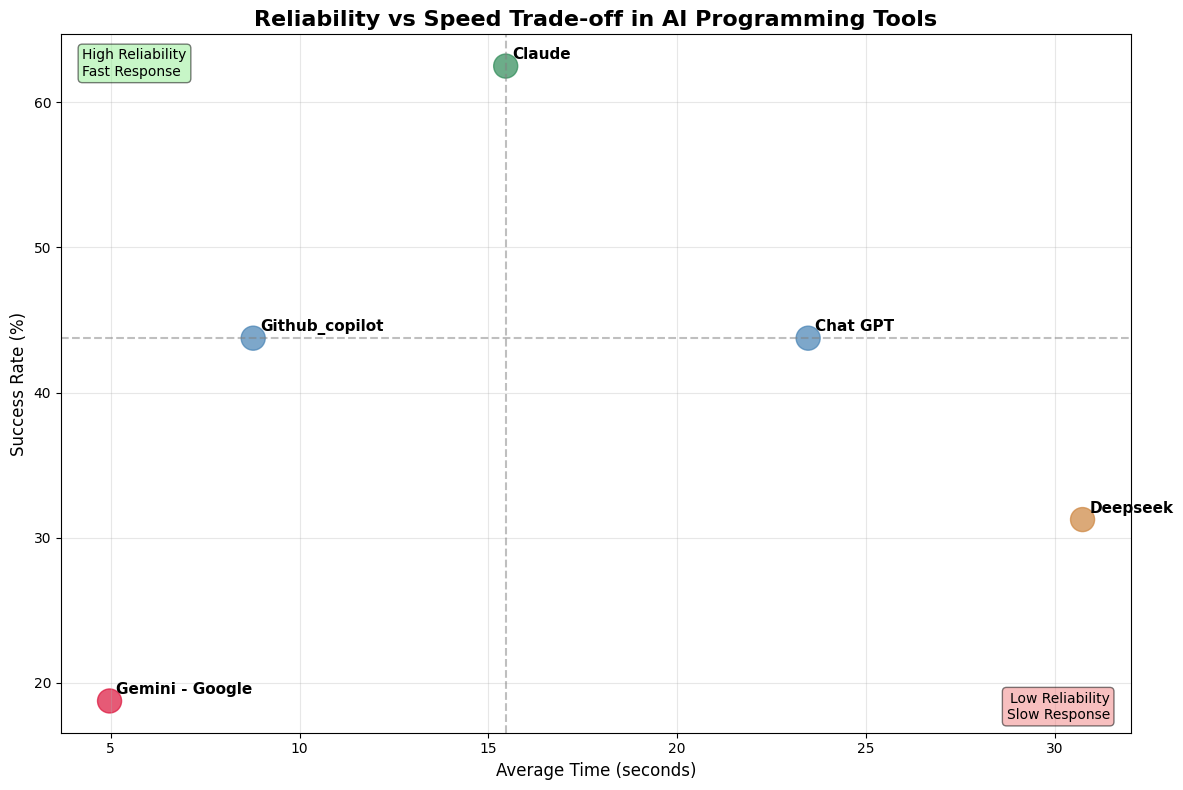

In [ ]:
# 4. Success Rate vs Speed Scatter Plot (Reliability vs Speed Trade-off)
plt.figure(figsize=(12, 8))
successful_data = summary_df[summary_df['Avg_Time'] > 0]
colors_map = ['#2E8B57', '#4682B4', '#4682B4', '#CD853F', '#DC143C']

scatter = plt.scatter(successful_data['Avg_Time'], successful_data['Success_Rate'], 
                     s=300, alpha=0.7, c=[colors_map[i] for i in range(len(successful_data))])
plt.title('Reliability vs Speed Trade-off in AI Programming Tools', fontsize=16, fontweight='bold')
plt.xlabel('Average Time (seconds)', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)

# Add tool labels to scatter plot
for i, row in successful_data.iterrows():
    plt.annotate(row['Tool'], (row['Avg_Time'], row['Success_Rate']), 
                xytext=(5, 5), textcoords='offset points', fontsize=11, fontweight='bold')

# Add quadrant labels
plt.axhline(y=successful_data['Success_Rate'].median(), color='gray', linestyle='--', alpha=0.5)
plt.axvline(x=successful_data['Avg_Time'].median(), color='gray', linestyle='--', alpha=0.5)

plt.text(0.02, 0.98, 'High Reliability\nFast Response', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))
plt.text(0.98, 0.02, 'Low Reliability\nSlow Response', transform=plt.gca().transAxes, 
         fontsize=10, horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='lightcoral', alpha=0.5))

plt.tight_layout()
plt.show()


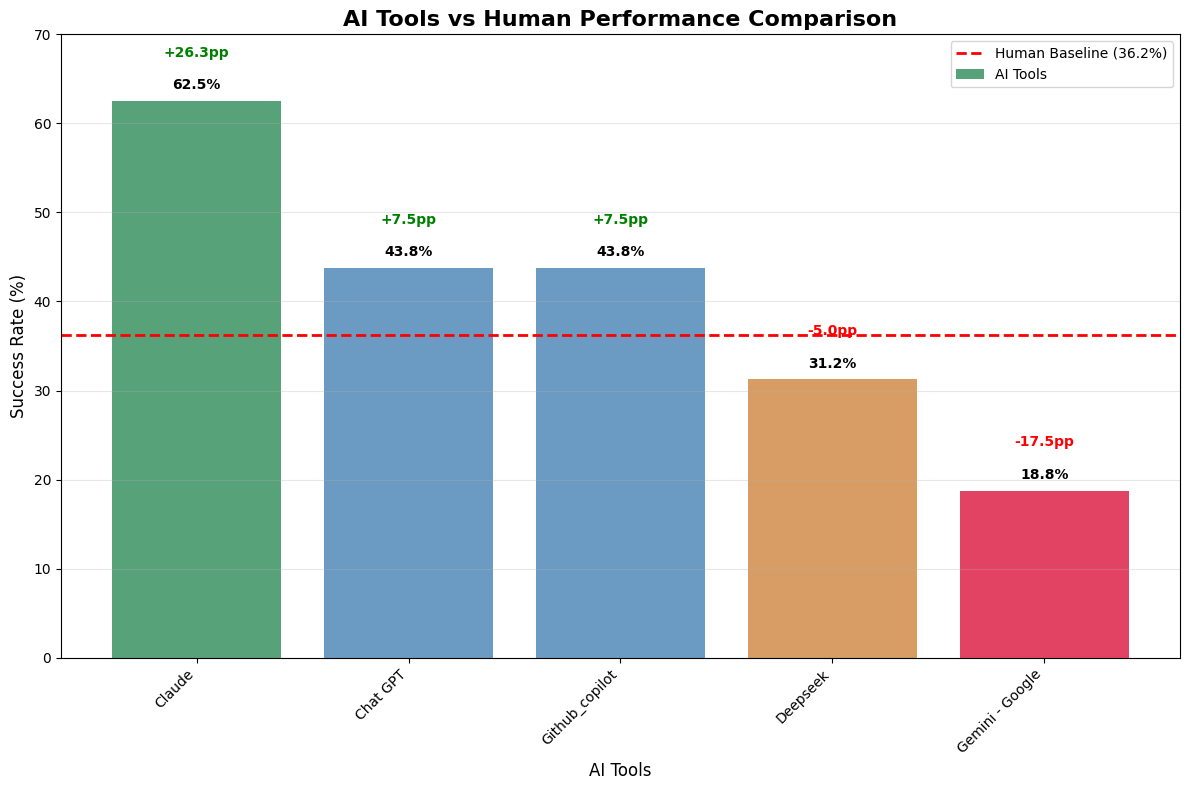

In [ ]:
# 5. AI Tools vs Human Performance Comparison
plt.figure(figsize=(12, 8))
human_baseline = 36.2  # Human teams average success rate

# Create comparison chart
x_pos = np.arange(len(summary_df))
bars = plt.bar(x_pos, summary_df['Success_Rate'], color=colors, alpha=0.8, label='AI Tools')
plt.axhline(y=human_baseline, color='red', linestyle='--', linewidth=2, 
           label=f'Human Baseline ({human_baseline}%)')

# Add value labels
for i, (bar, rate) in enumerate(zip(bars, summary_df['Success_Rate'])):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.title('AI Tools vs Human Performance Comparison', fontsize=16, fontweight='bold')
plt.xlabel('AI Tools', fontsize=12)
plt.ylabel('Success Rate (%)', fontsize=12)
plt.xticks(x_pos, summary_df['Tool'], rotation=45, ha='right')
plt.legend()
plt.ylim(0, 70)
plt.grid(axis='y', alpha=0.3)

# Add annotations for performance vs human
for i, rate in enumerate(summary_df['Success_Rate']):
    diff = rate - human_baseline
    if diff > 0:
        plt.text(i, rate + 5, f'+{diff:.1f}pp', ha='center', color='green', fontweight='bold', fontsize=10)
    else:
        plt.text(i, rate + 5, f'{diff:.1f}pp', ha='center', color='red', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()


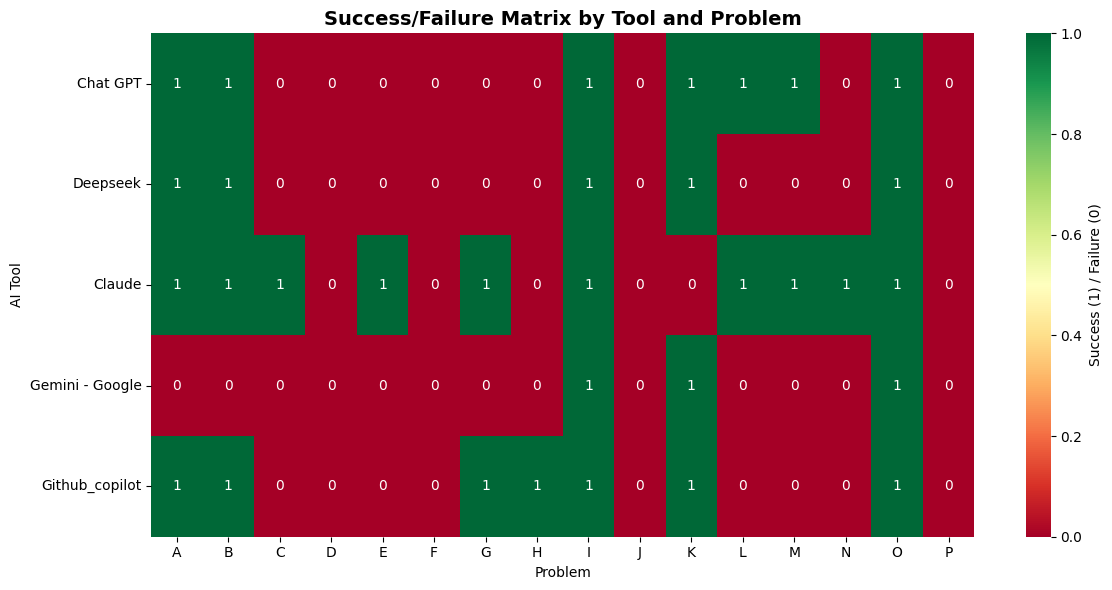

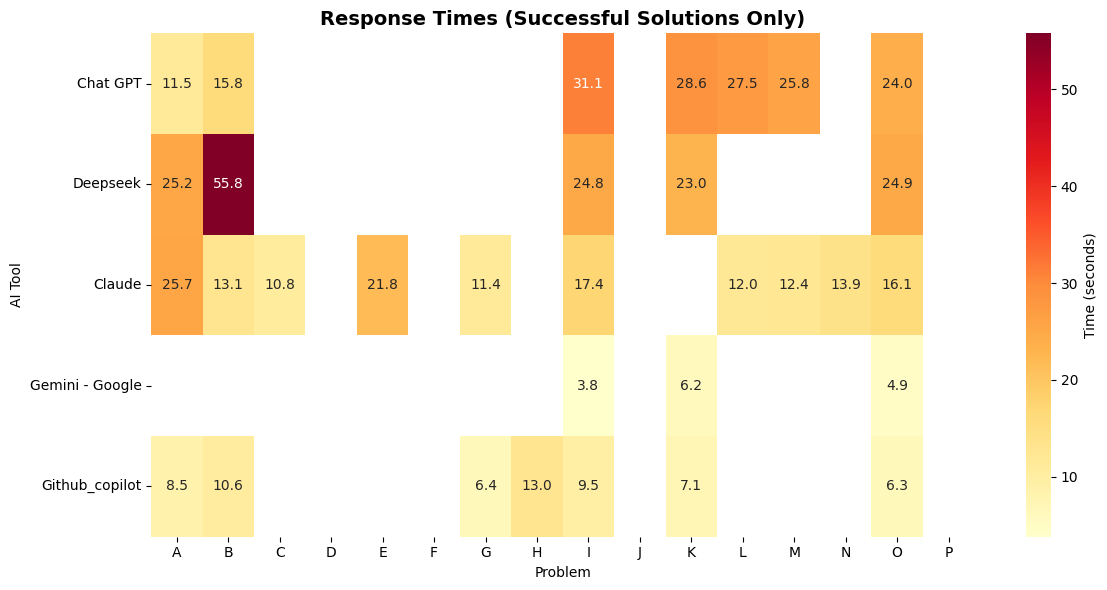

In [41]:
# Create success/failure heatmap
success_matrix = []
time_matrix = []

for tool_name in df['Ai_tools']:
    success_row = []
    time_row = []
    
    for problem in problems:
        row = df[df['Ai_tools'] == tool_name].iloc[0]
        time_val = row[problem]
        complexity_val = row[f'{problem}_time complexity']
        memory_val = row[f'{problem}_memory']
        
        # Check if rejected
        if (complexity_val == 'rejected' and memory_val == 'rejected') or not time_val or str(time_val).strip() == '':
            success_row.append(0)  # Failed
            time_row.append(np.nan)
        else:
            success_row.append(1)  # Success
            seconds = time_to_seconds(time_val)
            time_row.append(seconds if seconds is not None else np.nan)
    
    success_matrix.append(success_row)
    time_matrix.append(time_row)

# Create DataFrames for visualization
success_df = pd.DataFrame(success_matrix, columns=problems, index=df['Ai_tools'])
time_df = pd.DataFrame(time_matrix, columns=problems, index=df['Ai_tools'])

# Plot heatmaps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Success/Failure heatmap
sns.heatmap(success_df, annot=True, fmt='d', cmap='RdYlGn', 
            cbar_kws={'label': 'Success (1) / Failure (0)'}, ax=ax1)
ax1.set_title('Success/Failure Matrix by Tool and Problem', fontsize=14, fontweight='bold')
ax1.set_xlabel('Problem')
ax1.set_ylabel('AI Tool')

# Time heatmap (only for successful solutions)
# Mask failed attempts
mask = success_df == 0
sns.heatmap(time_df, annot=True, fmt='.1f', cmap='YlOrRd', mask=mask,
            cbar_kws={'label': 'Time (seconds)'})
plt.title('Response Times (Successful Solutions Only)', fontsize=14, fontweight='bold')
plt.xlabel('Problem')
plt.ylabel('AI Tool')
plt.tight_layout()
plt.show()


PROBLEM DIFFICULTY ANALYSIS

Problems ranked by difficulty (most difficult first):
Problem D: 0/5 tools succeeded (0.0% success rate)
Problem F: 0/5 tools succeeded (0.0% success rate)
Problem J: 0/5 tools succeeded (0.0% success rate)
Problem P: 0/5 tools succeeded (0.0% success rate)
Problem C: 1/5 tools succeeded (20.0% success rate)
  Average time for successful solutions: 10.8s
Problem E: 1/5 tools succeeded (20.0% success rate)
  Average time for successful solutions: 21.8s
Problem H: 1/5 tools succeeded (20.0% success rate)
  Average time for successful solutions: 13.0s
Problem N: 1/5 tools succeeded (20.0% success rate)
  Average time for successful solutions: 13.9s
Problem G: 2/5 tools succeeded (40.0% success rate)
  Average time for successful solutions: 8.9s
Problem L: 2/5 tools succeeded (40.0% success rate)
  Average time for successful solutions: 19.8s
Problem M: 2/5 tools succeeded (40.0% success rate)
  Average time for successful solutions: 19.1s
Problem A: 4/5 tools

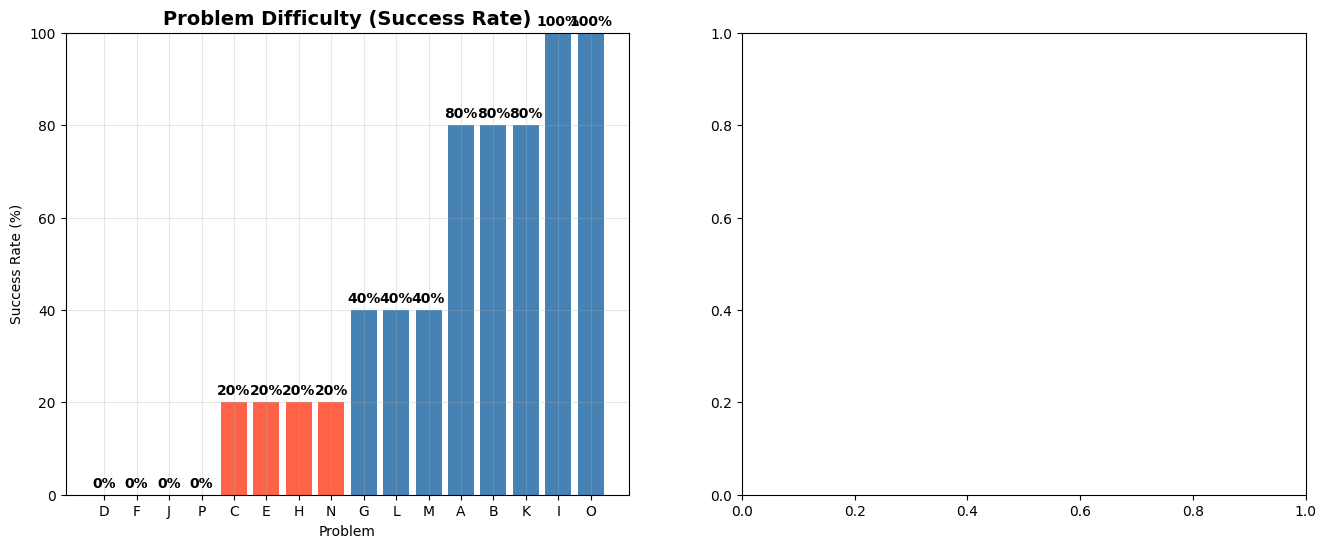

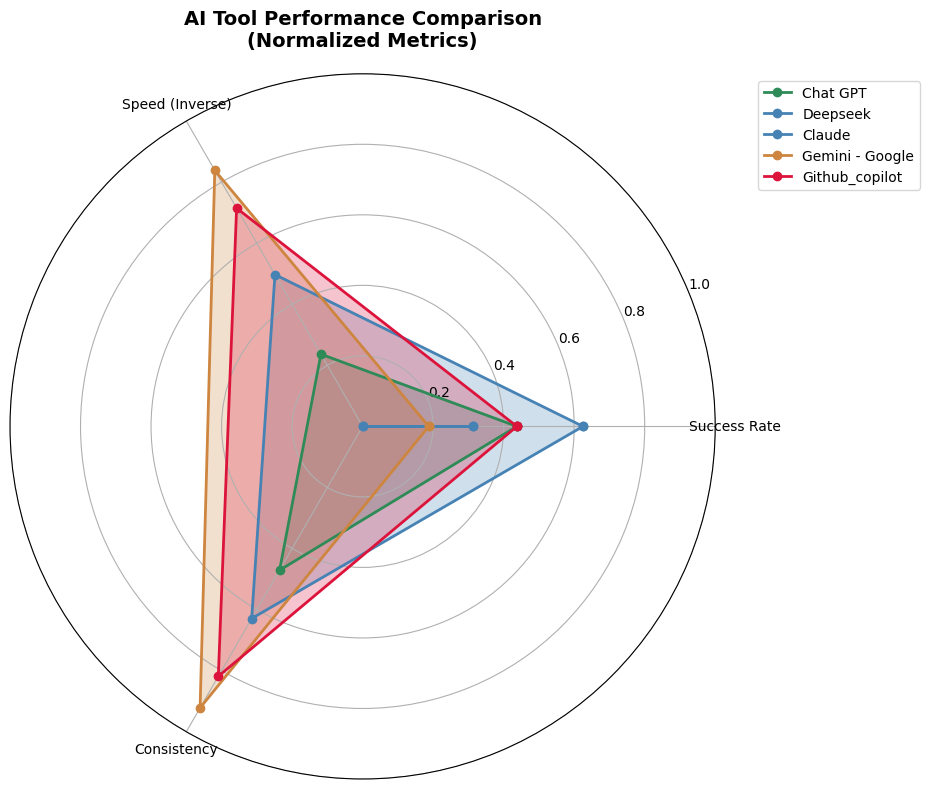

In [ ]:
# Problem difficulty analysis
print("\n" + "="*60)
print("PROBLEM DIFFICULTY ANALYSIS")
print("="*60)

problem_stats = []
for problem in problems:
    success_count = success_df[problem].sum()
    failure_count = len(df) - success_count
    success_rate = (success_count / len(df)) * 100
    
    # Get average time for successful solutions
    successful_times = time_df[problem].dropna()
    avg_time = successful_times.mean() if len(successful_times) > 0 else 0
    
    problem_stats.append({
        'Problem': problem,
        'Success_Count': success_count,
        'Failure_Count': failure_count,
        'Success_Rate': success_rate,
        'Avg_Time': avg_time
    })

problem_df = pd.DataFrame(problem_stats).sort_values('Success_Rate', ascending=True)

print("\nProblems ranked by difficulty (most difficult first):")
for _, row in problem_df.iterrows():
    print(f"Problem {row['Problem']}: {row['Success_Count']}/5 tools succeeded ({row['Success_Rate']:.1f}% success rate)")
    if row['Avg_Time'] > 0:
        print(f"  Average time for successful solutions: {row['Avg_Time']:.1f}s")

# Visualize problem difficulty
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Problem success rates
bars = ax1.bar(problem_df['Problem'], problem_df['Success_Rate'], 
               color=['#DC143C' if rate == 0 else '#FF6347' if rate < 40 else '#4682B4' for rate in problem_df['Success_Rate']])
ax1.set_title('Problem Difficulty (Success Rate)', fontsize=14, fontweight='bold')
ax1.set_ylabel('Success Rate (%)')
ax1.set_xlabel('Problem')
ax1.set_ylim(0, 100)
ax1.grid(True, alpha=0.3)

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.0f}%', ha='center', va='bottom', fontweight='bold')

# Tool comparison radar chart data
from math import pi

# Create radar chart for tool comparison
categories = ['Success Rate', 'Speed (Inverse)', 'Consistency']
fig2, ax3 = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))

angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
angles += angles[:1]  # Complete the circle

colors = ['#2E8B57', '#4682B4', '#4682B4', '#CD853F', '#DC143C']

for i, (tool_name, data) in enumerate(tool_analysis.items()):
    # Normalize values to 0-1 scale
    success_norm = data['success_rate'] / 100
    speed_norm = 1 - (data['avg_time'] / max([d['avg_time'] for d in tool_analysis.values() if d['avg_time'] > 0])) if data['avg_time'] > 0 else 0
    consistency_norm = 1 - (np.std(data['times']) / max([np.std(d['times']) if len(d['times']) > 1 else 0 for d in tool_analysis.values()])) if len(data['times']) > 1 else 0
    
    values = [success_norm, speed_norm, consistency_norm]
    values += values[:1]  # Complete the circle
    
    ax3.plot(angles, values, 'o-', linewidth=2, label=tool_name, color=colors[i])
    ax3.fill(angles, values, alpha=0.25, color=colors[i])

ax3.set_xticks(angles[:-1])
ax3.set_xticklabels(categories)
ax3.set_ylim(0, 1)
ax3.set_title('AI Tool Performance Comparison\n(Normalized Metrics)', size=14, fontweight='bold', pad=20)
ax3.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
ax3.grid(True)

plt.tight_layout()
plt.show()

In [32]:
# Final Summary and Key Insights
print("\n" + "="*80)
print("FINAL SUMMARY: KEY INSIGHTS FOR RESEARCH PAPER")
print("="*80)

# 1. Best and worst performers
best_tool = summary_df.iloc[0]
worst_tool = summary_df.iloc[-1]

print(f"\n1. PERFORMANCE RANKING:")
print(f"   🥇 Best:  {best_tool['Tool']} - {best_tool['Success_Rate']:.1f}% success rate")
print(f"   🥉 Worst: {worst_tool['Tool']} - {worst_tool['Success_Rate']:.1f}% success rate")
print(f"   📊 Performance gap: {best_tool['Success_Rate']/worst_tool['Success_Rate']:.1f}x difference")

# 2. Speed vs reliability trade-off
print(f"\n2. SPEED vs RELIABILITY TRADE-OFF:")
fastest = summary_df[summary_df['Avg_Time'] > 0].sort_values('Avg_Time').iloc[0]
print(f"   ⚡ Fastest: {fastest['Tool']} ({fastest['Avg_Time']:.1f}s avg) but only {fastest['Success_Rate']:.1f}% success rate")
print(f"   🎯 Most reliable: {best_tool['Tool']} ({best_tool['Success_Rate']:.1f}% success) with {best_tool['Avg_Time']:.1f}s avg time")

# 3. Most challenging problems
impossible_problems = problem_df[problem_df['Success_Rate'] == 0]
print(f"\n3. PROBLEM DIFFICULTY:")
print(f"   🚫 Impossible problems (0% success): {', '.join(impossible_problems['Problem'].tolist())}")
print(f"   📈 Easiest problem: {problem_df.iloc[-1]['Problem']} ({problem_df.iloc[-1]['Success_Rate']:.0f}% success)")
print(f"   📉 Hardest solvable: {problem_df[problem_df['Success_Rate'] > 0].iloc[0]['Problem']} ({problem_df[problem_df['Success_Rate'] > 0].iloc[0]['Success_Rate']:.0f}% success)")

# 4. Key statistics for paper
total_attempts = len(df) * len(problems)
total_successes = sum([data['problems_solved'] for data in tool_analysis.values()])
overall_success_rate = (total_successes / total_attempts) * 100

print(f"\n4. OVERALL STATISTICS:")
print(f"   📊 Overall AI success rate: {overall_success_rate:.1f}% ({total_successes}/{total_attempts} attempts)")
print(f"   🔢 Total problems attempted: {total_attempts}")
print(f"   ✅ Total successful solutions: {total_successes}")
print(f"   ❌ Total rejections: {total_attempts - total_successes}")

# 5. Recommendations
print(f"\n5. PRACTICAL RECOMMENDATIONS:")
print(f"   ✅ For maximum reliability: Use {best_tool['Tool']}")
print(f"   ⚡ For speed (if reliability not critical): Use {fastest['Tool']}")
print(f"   ❌ Avoid for critical tasks: {worst_tool['Tool']} (too many failures)")
print(f"   🎯 Sweet spot: Balance of speed and reliability varies by use case")

print(f"\n6. RESEARCH IMPLICATIONS:")
print(f"   • Success rate is more important than speed for practical applications")
print(f"   • AI tools show dramatic performance variation (18.8% to 62.5% success rates)")
print(f"   • Some AI tools perform worse than human baseline (36.2% average)")
print(f"   • Tool selection should be based on empirical evaluation, not popularity")

print("\n" + "="*80)



FINAL SUMMARY: KEY INSIGHTS FOR RESEARCH PAPER

1. PERFORMANCE RANKING:
   🥇 Best:  Claude - 62.5% success rate
   🥉 Worst: Gemini - Google - 18.8% success rate
   📊 Performance gap: 3.3x difference

2. SPEED vs RELIABILITY TRADE-OFF:
   ⚡ Fastest: Gemini - Google (5.0s avg) but only 18.8% success rate
   🎯 Most reliable: Claude (62.5% success) with 15.5s avg time

3. PROBLEM DIFFICULTY:
   🚫 Impossible problems (0% success): D, F, J, P
   📈 Easiest problem: O (100% success)
   📉 Hardest solvable: C (20% success)

4. OVERALL STATISTICS:
   📊 Overall AI success rate: 40.0% (32/80 attempts)
   🔢 Total problems attempted: 80
   ✅ Total successful solutions: 32
   ❌ Total rejections: 48

5. PRACTICAL RECOMMENDATIONS:
   ✅ For maximum reliability: Use Claude
   ⚡ For speed (if reliability not critical): Use Gemini - Google
   ❌ Avoid for critical tasks: Gemini - Google (too many failures)
   🎯 Sweet spot: Balance of speed and reliability varies by use case

6. RESEARCH IMPLICATIONS:
   • S